# Loan Approval Prediction, a classification problem

### How accurate will we be predicting determinations for loan approval requests?

In [ ]:
# Dataset location - https://www.kaggle.com/shaijudatascience/loan-prediction-practice-av-competition

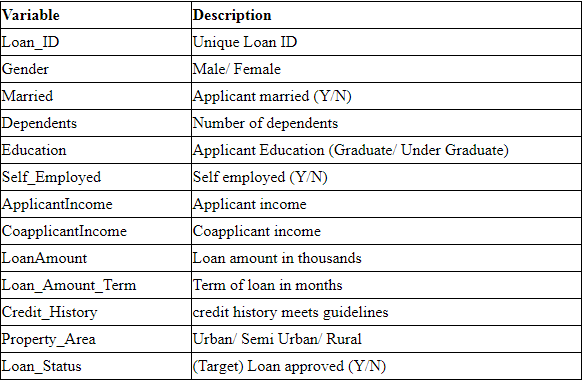

In [5]:
from IPython.display import Image

Image(filename='../images/loan_variables.png')

In [ ]:
# There are 13 variables in the dataset.
# 'Loan_Status' is our target; we are attempting to predict loan approvals.
# To address any potential for data leakage, we will refrain from creating 
# any new features using the target, we won't perform any fitting using our 
# validation sets, and we will watch for any significant declines in our 
# models' performance when scoring our validation sets. 

# EDA - Let's import and explore the data

In [7]:
# Import packages and package classes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [8]:
# It's a small dataset, but > the threshold of 500 observations

train = pd.read_csv('../data/class-project/LoanApproval/train_data.csv')

print(train.shape)
train.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [11]:
for col in list(train.columns):
    print(col, train[col].nunique())

Loan_ID 614
Gender 2
Married 2
Dependents 4
Education 2
Self_Employed 2
ApplicantIncome 505
CoapplicantIncome 287
LoanAmount 203
Loan_Amount_Term 10
Credit_History 2
Property_Area 3
Loan_Status 2


In [12]:
print(train['Dependents'].unique())

['0' '1' '2' '3+' nan]


In [ ]:
# 'Loan_ID', high cardinality column, variable is a unique identifier and will be dropped.
# 'Gender', binary categorical variable, assignment == Male/Female, NaN objects hold no meaning.
# 'Married', binary categorical feature, assignment == Y/N, NaN objects hold no meaning.
# 'Dependents', categorical feature, assignment == 0/1/2/3+, NaN objects hold no meaning.
# 'Education', binary categorical feature, assignement == Graduate/Not Graduate, NaN objects hold no meaning.
